<h3>Introduction to Data Science 2024: Assignment 2</h3>
<h3>k−Nearest Neighbors Classification</h3>
<h4>Andrea Schröter, kbn999</h4>


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import preprocessing

<h3> Exercise 1 </h3>

In [2]:
column_names = ['temperature','rel_humidity','light','CO2','humidity_ratio','occupancy'] 
dataTrain = pd.read_csv("OccupancyTrain.csv", header=None, names=column_names) # read data
dataTest = pd.read_csv("OccupancyTest.csv", header=None, names=column_names) # read data

# split input variables and labels
XTrain = dataTrain.iloc[:, : -1].values # use all rows and all but the last column
YTrain = dataTrain.iloc[:, -1].values # use all rows, only the last column
XTest = dataTest.iloc[:, : -1].values
YTest = dataTest.iloc[:, -1].values
dataTrain.head()

,temperature,rel_humidity,light,CO2,humidity_ratio,occupancy
0,21.29,21.1,0.00,592.50,0.003297,0.0
1,22.10,26.6,464.00,1073.25,0.004375,1.0
2,19.39,27.2,0.00,463.00,0.003783,0.0
3,20.60,19.5,0.00,435.00,0.002919,0.0
4,21.50,33.5,475.25,1281.50,0.005320,1.0


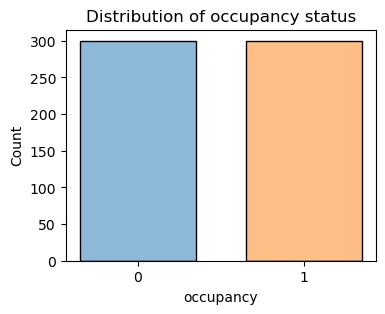

In [3]:
# visualize distribution of occupancy status
plt.figure(figsize=(4, 3))
sns.histplot(data=dataTrain, x='occupancy', hue='occupancy', discrete=True, shrink=.7, legend=False).set_title("Distribution of occupancy status")
plt.xticks([0, 1])
plt.show() 

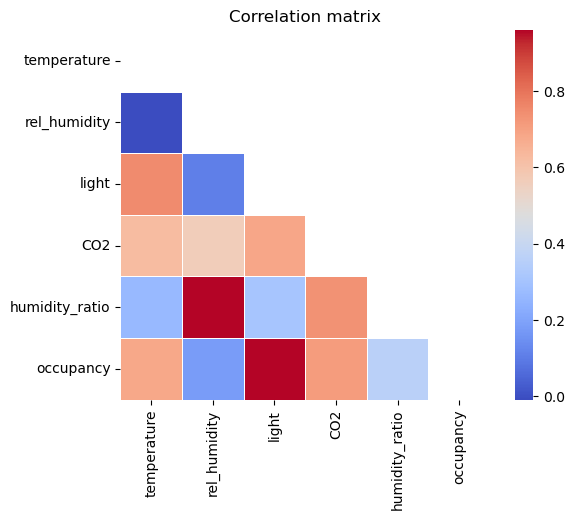

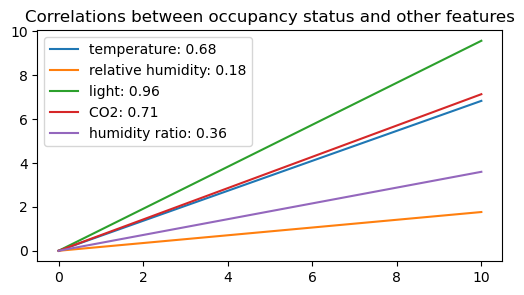

In [4]:
# Option1: visualize correlation coefficients via heatmap (cf. https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

corr = dataTrain.corr() # compute the correlation matrix

mask = np.triu(np.ones_like(corr, dtype=bool)) # create mask to hide the upper triangle

sns.heatmap(corr, cmap='coolwarm',
            square=True, mask=mask,linewidths=.5).set_title("Correlation matrix") # draw heatmap
plt.show()


# Option 2: plot correlation coefficients as lines

features = ['temperature','rel_humidity','light','CO2','humidity_ratio'] 
feature_names = ["temperature","relative humidity","light","CO2","humidity ratio"] # features written out


x_values = np.linspace(0, 10, 10) # x values

plt.figure(figsize=(6, 3))

for i,feature in enumerate(features):
    corr = sp.stats.pearsonr(dataTrain[feature], dataTrain["occupancy"])[0] # calculate correlation coefficient
    y_values = corr * x_values
    plt.plot(x_values, y_values, label=f"{feature_names[i]}: {round(corr,2)}") # plot line

plt.title("Correlations between occupancy status and other features")
plt.legend()
plt.show()

#### Explanation:

The first plot shows the frequency of buildings in the dataset that are occupied (occupancy=1) and not occupied (occupancy=0). We can see that the data set is balanced because both categories appear 300 times. I chose to visualize the distribution as a histogram since it represents a simple and effective way to show the frequency of a value in the data set.

In order to visualize the correlations, I chose a heat map. Thus, in the second plot we can see the correlations between all features in the data set where correlations are indicated by colors (ranging from weak correlations in blue to strong ones in red). First of all, there are no negative correlations. Moreover, the feature "light" has the strongest correlation to "occupancy", meaning that if the value for light increases, the value for occupancy increases, too (treating it as a continous variable here since it is binary encoded). The lowest correlation persists between occupancy and the humidity ratio. However, as we are only interested in the relationship between the target "occupancy" and the remaining features, the heatmap may be overly informative. Another option would be to plot the correlations as lines that have the correlation coefficients as slopes. Again, we observe that the temperature of a building has the highest correlation to its occupancy status (0.96), followed by CO2 concentration (0.71), temperature (0.68) and the humidty ratio (0.36) and lastly as a very weak correlation (0.36) the relative humidity.

<h3> Exercise 2 </h3>

In [5]:
knn = KNeighborsClassifier(n_neighbors=1) # instantiate 1-Nearest Neighbour classifier

knn.fit(XTrain,YTrain) # train classifier on training data

accTest = accuracy_score(YTest, knn.predict(XTest)) # obtain accuracy score for the models performance on the testset

print(accTest)

0.9775


#### Explanation:
The accuracy on the test set is very high (0.9775), indicating that the trained 1-Nearest Neighbour model performs very well on unseen data, even though k=1, so only one single nearest neighbor is used for classifying the occupancy status of a building. However, it is crucial to test more values fo k to choose the optimal k and to potentially use additional evaluation metrics to assess the models performance. 

<h3> Exercise 3 </h3>


In [6]:
def k_selection_kFoldCV(XTrain,YTrain): 
    
    k_values = [1,3,5,7,9,11] # k-values to consider

    accuracies = [] # store accuracies for different ks

    cv = KFold(n_splits=5) # create indices for Cross Validation (CV)

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)

        fold_accuracies = [] # store accuracies for all folds for one k

        for train, test in cv.split(XTrain): # loop over CV folds
            XTrainCV , XTestCV , YTrainCV , YTestCV = XTrain[train], XTrain[test], YTrain[train], YTrain[test]

            knn.fit(XTrainCV, YTrainCV) # train classfier on test data

            acc = accuracy_score(YTestCV, knn.predict(XTestCV)) # obtain accuracy for fold

            fold_accuracies.append(acc)

        mean_acc = np.mean(fold_accuracies) # get mean accuracy for all folds for one k
        accuracies.append(mean_acc) # add average accuracy for one k to the accuracies list

    for i, accuracy in enumerate(accuracies):
        print(f"For k={k_values[i]} the accuracy {accuracy} is obtained.")

    k_best_index = np.argmax(accuracies) # get index of the highest accuracy
    k_best = k_values[k_best_index] # get k value that has highest accuracy
    print(f"The highest accuracy of {accuracies[k_best_index]} can be observed for k = {k_best}.")
    # Assignment 2, ex3: if we have several values for our hyperparameter which reach the optimal accuracy, we prefer the simplest model, that is, the minimun k that reaches optimal accuracy.
    return k_best

k_best = k_selection_kFoldCV(XTrain,YTrain)

For k=1 the accuracy 0.9816666666666667 is obtained.
For k=3 the accuracy 0.9916666666666668 is obtained.
For k=5 the accuracy 0.9916666666666668 is obtained.
For k=7 the accuracy 0.9916666666666668 is obtained.
For k=9 the accuracy 0.9916666666666668 is obtained.
For k=11 the accuracy 0.99 is obtained.
The highest accuracy of 0.9916666666666668 can be observed for k = 3.


#### Explanation: 


To determine the optimal value of k for the k-NN classifier, a 5-fold cross-validation procedure was employed. For each value of k, the training data was divided into five folds. During each iteration, the classifier was trained on four folds and evaluated on the remaining fold. The accuracies obtained across all fold variations were then averaged to calculate the final accuracy score for that specific k value.

K-fold cross-validation, where k denotes the number of folds, is particularly beneficial for obtaining a more stable accuracy score, especially when the training data is limited, as noted by Chollet (2018: 99). Larger values of k tend to reduce noise in the data and result in smoother decision boundaries (Ma et al. 2014). However, they may also lead to underfitting. Conversely, smaller values of k can increase the risk of overfitting (Jadhav et al. 2016). Moreover, higher values of k are computationally more expensive since they involve examining more neighbors of a data point to predict its label.

In the conducted test, the optimal value for k was found to be 3, indicating that k=3 yields the highest accuracy while minimizing k. It's worth noting that the difference in accuracy between k=1 and k=3 was minimal.


<h3> Exercise 4 </h3>

In [7]:
def kBest_NN(k_best,XTrain,YTrain,XTest,YTest):

    knn = KNeighborsClassifier(n_neighbors=k_best)
    knn.fit(XTrain,YTrain) # train classifier on training data
    accTest = accuracy_score(YTest, knn.predict(XTest)) # obtain accuracy score for the models performance on the testset
    accTrain = accuracy_score(YTrain, knn.predict(XTrain)) # obtain accuracy score for the models performance on the training set
    print(f"Accuracy when tested on the training set: {accTrain}") # train accuracy
    print(f"Accuracy when tested on the test set: {accTest}") # test accuracy
    return accTrain, accTest

kBest_NN(k_best, XTrain,YTrain, XTest, YTest)

Accuracy when tested on the training set: 0.9933333333333333
Accuracy when tested on the test set: 0.9875


(0.9933333333333333, 0.9875)

#### Explanation:

Training a k-best-NN classifier (k=3 as obtained in the previous exercise) yields an accuracy of approx. 0.99 indicating almost perfect performance on the training set. The model has learned to classify the occupancy status with high accuracy. The accuracy obtained when testing on the test set is only slighlty lower (0.9875), indicating that model also generalizes or performs well on unseen data. The accuracy of testing on the test set is higher than the accuracy obtained in the second exercise (0.9775), suggesting that k=3 is a better choice of the models parameters than k=1.

<h3> Exercise 5 </h3>

The correct normalization version is 1 because it first computes the mean and standard deviation of the training data and then normalizes the data on the training and test set using the parameters from the training set. Version 2 would lead to inconsistent scaling of test and training data as we normalize the training data based on mean and standard deviation of the training data and the test data based on parameters obtained from the test set. This would be problematic, since it would be more difficult to generalize to new data since we have different values for our features. The third version reverses the splitting of training and test data and calculates the mean and sd for the entire test set before transforming the train and test data. Since we want to test the models performance on unseen data, we should avoid information leakage from the testing into the training set which is clearly done here by using the mean and sd of the entire data set to normalize the train and test set $^{1}$. In general, we want an unbiased estimate of the models performance.

$^{1}$ https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb, retrieved Feb 24, 2024.

In [8]:
from sklearn import preprocessing
# version1
scaler = preprocessing.StandardScaler().fit(XTrain) # obtain mean and sd of training set
XTrainN = scaler.transform(XTrain) # normalize training set
XTestN = scaler.transform(XTest) # normalize test set

# k selection

k_best = k_selection_kFoldCV(XTrainN,YTrain)
kBest_NN(k_best, XTrainN,YTrain, XTestN,YTest)

For k=1 the accuracy 0.9833333333333334 is obtained.
For k=3 the accuracy 0.9916666666666666 is obtained.
For k=5 the accuracy 0.9916666666666666 is obtained.
For k=7 the accuracy 0.9916666666666666 is obtained.
For k=9 the accuracy 0.9899999999999999 is obtained.
For k=11 the accuracy 0.9916666666666668 is obtained.
The highest accuracy of 0.9916666666666668 can be observed for k = 11.
Accuracy when tested on the training set: 0.9916666666666667
Accuracy when tested on the test set: 0.98


(0.9916666666666667, 0.98)

|        | k-best | Accuracy after testing on training set | Accuracy after testing on test set |
|--------|--------|----------------------------------------|------------------------------------|
| Before Normalizing |   3    |           0.9933333333333333    |             0.9875         |                            |
| After Normalizing  |     11  |        0.9916666666666667           |       0.98  |

#### Explanation:

As we can see in the table below, after normalizing, the new best value for k is 11 (instead of 3). One explanation for this behaviour might be that we reduced the range of the feature values by normalizing them. This might effect the results of the distance metric used in the algorithm (cf. Ma et al. 2014) or we simply have to look at more neighbours to effectively capture patterns in the data. The accuracies obtained after testing the models performance on training and test sets however are similar (0.9933 % (training set) and 0.9875 % (test set) before normalizing and 0.9917 and 0.98 after normalizing), although the accuracies are slightly lower after normalizing.

<h3> References </h3>


Chollet, F. (2018). Deep learning with Python. Simon and Schuster.

Jadhav, S. D., & Channe, H. P. (2016). Comparative study of K-NN, naive Bayes and decision tree classification techniques. International Journal of Science and Research (IJSR), 5(1), 1842-1845.

Ma, C. M., Yang, W. S., & Cheng, B. W. (2014). How the parameters of k-nearest neighbor algorithm impact on the best classification accuracy: In case of parkinson dataset. Journal of Applied Sciences, 14(2), 171-176.

ChatGPT was used to create markdown tables and as a writing tool.